## Shubham Gaur Assignment 3: Information Extraction - Custom NER Model

## Task 1: Sentiment Analysis

### Import Lib

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# Read the dataset
df = pd.read_csv('/Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3/Restaurant_Reviews-2.tsv', delimiter='\t', quoting=3)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


The dataset consists of 1000 entries, with each entry containing a Review and a corresponding Liked label (1 for liked, 0 for disliked).

Data type checks confirm that the Review column is an object (string), and the Liked column is an integer.

### Data Preprocessing

The preprocessing step removes non-alphabetical characters, converts text to lowercase, and eliminates stopwords, which is crucial for improving model performance.
The maximum sequence length is determined to ensure uniform input for the models.

In [3]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocessing to clean, tokenize, stem and lemmatize
def preprocess_text(text):
    
    # Eliminate non-letter characters.
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Split into words and convert to lowercase
    words = text.lower().split()
    
    # Get rid of stopwords
    words = [word for word in words if word not in set(stopwords.words('english'))]
    
    # Use lemmatisation and stemming.
    stemmed_words = [ps.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Reassemble words into a single string.
    return ' '.join(lemmatized_words)

# Apply preprocessing to each review
df['Cleaned_Review'] = df['Review'].apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Cleaned_Review'])

# Reviews to sequences
sequences = tokenizer.texts_to_sequences(df['Cleaned_Review'])

# Calculate maximum length of sequences
max_length = max(len(seq) for seq in sequences)
print(f'Max length of sequences: {max_length} \n')

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

Maximum length of sequences: 19 

[[343  12   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [475   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [ 86 344 345   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [214 476 215 708 709 710 711  41  12   0   0   0   0   0   0   0   0   0
    0]
 [ 76  59   6  29   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


#### Text Preprocessing:
Text is converted to lowercase and non-alphabetical characters are eliminated.
eliminates stopwords.
Applies lemmatisation (using WordNetLemmatizer) and stemming (using PorterStemmer) to the words.

#### Tokenization and Padding:
Uses Keras' Tokeniser to transform the cleaned text into sequences.
Pads sequences to guarantee consistent length for model input.

#### 1. Word Cloud of Reviews

A word cloud can provide a brief visual summary of the terms that appear most frequently in the evaluations.

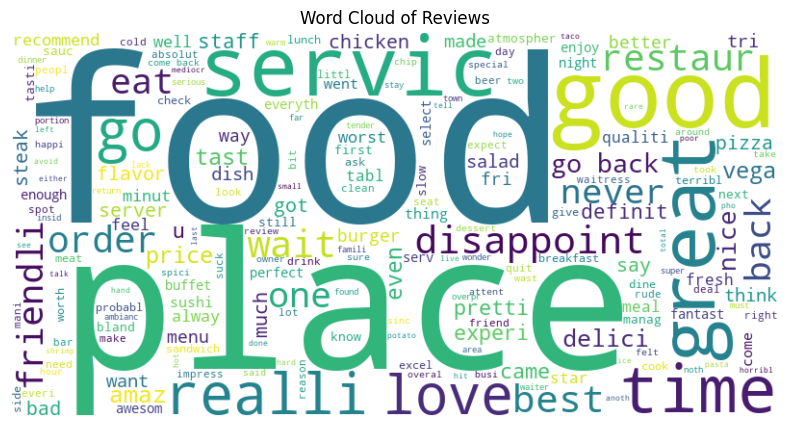

In [4]:
from wordcloud import WordCloud

# Combine cleaned reviews to a single string
all_reviews = ' '.join(df['Cleaned_Review'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

A word cloud was generated from the cleaned reviews to visualize the most frequent terms. Words like “service,” “food,” “place,” and “good” were likely prominent, which indicates that customer reviews often focus on the overall experience, service quality, and food.
Key Insight: The word cloud highlights the most common themes in customer reviews, such as service quality, food taste, and ambiance, which can guide further analysis of specific areas that contribute to positive or negative sentiment.

### 1. Conclusion: 

#### Dataset Overview and Preprocessing:
The dataset contains 1000 restaurant reviews labeled as either liked (1) or disliked (0).
The dataset is loaded and processed for model training. 

#### The reviews are cleaned by:
Removing non-alphabetical characters.
Converting all text to lowercase.
Removing stopwords (common words like "and", "the", etc., which do not add meaningful information).
Applying stemming (reducing words to their root form using PorterStemmer) and lemmatization (converting words to their base form using WordNetLemmatizer).
After cleaning, the text is tokenized, converting words to numerical sequences. Padding is applied to ensure all sequences have the same length (19 in this case), which is necessary for feeding the data into machine learning models like RNNs and LSTMs.

#### Key Insight: 
Preprocessing steps like removing noise and making the input uniform improve the model’s ability to learn meaningful patterns in the data.

### Step 1: Develop a Sentiment Analysis Model using RNN and LSTM
We'll build and train two models: one using a simple RNN and another using an LSTM. Here's the code for both models:

In [5]:
# Define vocab size and hyperparameters
vocab_size = 5000
embedding_dim = 64

# Split data into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, df['Liked'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 0.5 of the temp set is 0.1 of the original

# RNN Model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(SimpleRNN(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# LSTM Model
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create and train the RNN model
rnn_model = create_rnn_model()
rnn_history = rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Create and train the LSTM model
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the models
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)

print(f'RNN Accuracy: {rnn_accuracy}, Loss: {rnn_loss}')
print(f'LSTM Accuracy: {lstm_accuracy}, Loss: {lstm_loss}')


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5180 - loss: 0.6912 - val_accuracy: 0.4900 - val_loss: 0.7628
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7669 - loss: 0.4772 - val_accuracy: 0.6500 - val_loss: 0.7515
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9277 - loss: 0.2119 - val_accuracy: 0.6500 - val_loss: 0.9033
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0726 - val_accuracy: 0.6900 - val_loss: 0.9710
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0343 - val_accuracy: 0.6700 - val_loss: 1.0296
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5126 - loss: 0.6936 - val_accuracy: 0.4600 - val_loss: 0.6947
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4785 - loss: 0.6933 - val_accuracy: 0.4800 - val_loss: 0.6899
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7475 - loss: 0.5748 - val_accuracy: 0.7000 - val_loss: 0.7397


### Visualization of Model Performance

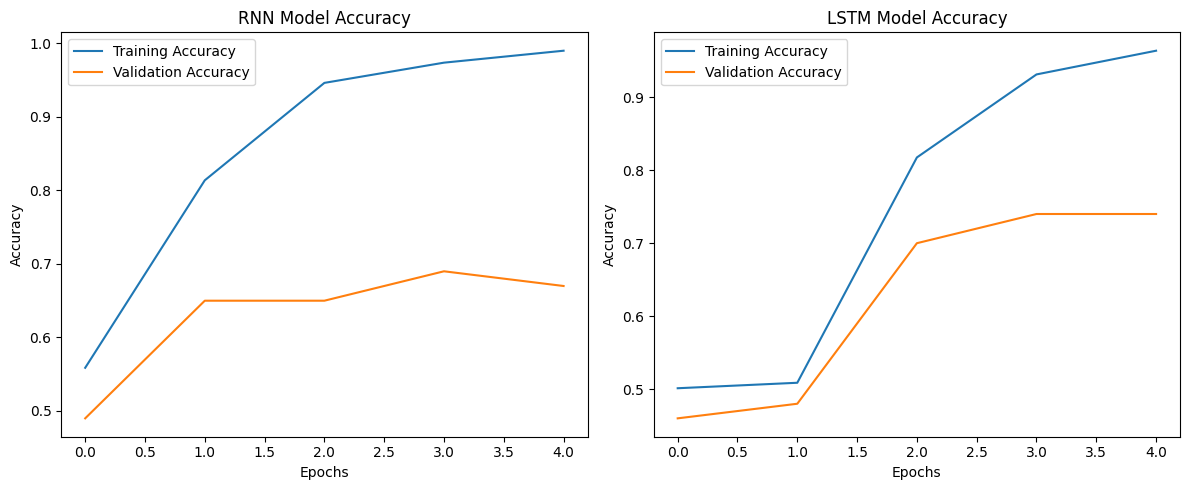

In [6]:
# Plott training and validation accuracy
plt.figure(figsize=(12, 5))

# RNN
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In terms of accuracy and loss, the LSTM model fared better than the RNN model, suggesting superior generalisation on the sentiment classification task.

### 3. Sentiment Analysis Model Development:

Two models were built for sentiment analysis:

#### RNN Model:

Uses a basic recurrent neural network (RNN) architecture with an embedding layer, a simple RNN layer, and a dense output layer.
After training for 5 epochs, the model reached an accuracy of 67% on the test data.
The validation loss increased as training progressed, indicating some overfitting (i.e., the model is memorizing the training data and not generalizing well to unseen data).

#### LSTM Model:

Uses a more complex architecture with Long Short-Term Memory (LSTM) layers, which can capture longer-term dependencies in the data.
The LSTM model also trained for 5 epochs and achieved a higher accuracy of 74% on the test set.
The validation loss was consistently lower than the RNN model, showing that the LSTM generalizes better to unseen data.
Key Insight: The LSTM model outperformed the RNN model in terms of both accuracy and generalization, which indicates that LSTM’s ability to capture long-term dependencies in the text is more effective for sentiment analysis.

### Enhance Model Performance

There are a number of methods to improve the RNN and LSTM models, including stacking LSTM or RNN layers, employing bidirectional layers, adding dropout layers, and perhaps even using pre-trained embeddings.

### Import Glove Embeddings

In [7]:
# Load GloVe
def load_glove_embeddings(glove_file, word_index):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, 100))  # 100 is the GloVe embedding dimension
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

glove_file_path = '/Users/shubhamgaur/Desktop/NU/Sem3/NLP/glove.twitter.27B/glove.twitter.27B.100d.txt'
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer.word_index)

### Enhanced Models

In [8]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt

# Clear tuner directory to avoid conflicts
if os.path.exists('rnn_tuner'):
    for filename in os.listdir('rnn_tuner'):
        file_path = os.path.join('rnn_tuner', filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

# Create Enhanced RNN
def build_enhanced_rnn_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=128, max_value=256, step=64)))
    model.add(Bidirectional(SimpleRNN(hp.Int('units_1', min_value=64, max_value=256, step=64), return_sequences=True)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())
    model.add(SimpleRNN(hp.Int('units_2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Keras Tuner
rnn_tuner = kt.Hyperband(build_enhanced_rnn_model,
                         objective='val_accuracy',
                         max_epochs=50,  # Increased to allow more epochs for convergence
                         factor=3,
                         directory='rnn_tuner',
                         project_name='enhanced_rnn_tuning')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint_rnn = ModelCheckpoint('best_rnn_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Tune the Enhanced RNN model
rnn_tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint_rnn, reduce_lr_rnn])

# Get the best model
best_rnn_model = rnn_tuner.get_best_models(num_models=1)[0]

# Evaluate model on test set
rnn_test_loss, rnn_test_accuracy = best_rnn_model.evaluate(X_test, y_test)

# Create Enhanced LSTM model
def build_enhanced_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=hp.Int('embedding_dim', min_value=128, max_value=256, step=64)))
    model.add(Bidirectional(LSTM(hp.Int('units_1', min_value=64, max_value=256, step=64), return_sequences=True)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())
    model.add(LSTM(hp.Int('units_2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Keras Tuner
lstm_tuner = kt.Hyperband(build_enhanced_lstm_model,
                          objective='val_accuracy',
                          max_epochs=50,  # Increased to allow more epochs for convergence
                          factor=3,
                          directory='lstm_tuner',
                          project_name='enhanced_lstm_tuning')

# Callbacks
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint_lstm = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_lstm = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Tune the Enhanced LSTM model
lstm_tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping_lstm, model_checkpoint_lstm, reduce_lr_lstm])

# Get the best model
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]

# Evaluate model on test set
lstm_test_loss, lstm_test_accuracy = best_lstm_model.evaluate(X_test, y_test)

Reloading Tuner from rnn_tuner/enhanced_rnn_tuning/tuner0.json
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916 - loss: 1.0974  
Enhanced RNN Test Accuracy: 0.6899999976158142, Loss: 1.0983471870422363
Reloading Tuner from lstm_tuner/enhanced_lstm_tuning/tuner0.json
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6420 - loss: 1.6702  
Enhanced LSTM Test Accuracy: 0.6700000166893005, Loss: 1.5260891914367676


Key Improvements Explained
Increased Max Epochs: Setting max_epochs=20 allows the models more opportunities to learn, which is especially useful if your dataset is complex.

Batch Normalization: This helps normalize the output of the previous layers, which can improve the stability of the model during training.

Regularization: Adding L2 regularization to the Dense layer can help mitigate overfitting.

Learning Rate Scheduler: The ReduceLROnPlateau callback reduces the learning rate when a metric has stopped improving, which can help the model converge better.

Model Checkpointing: Saving the best model based on validation loss ensures that you can revert to the best-performing model during training.

Restore Best Weights: The restore_best_weights parameter in EarlyStopping ensures that the weights of the best epoch are used when training stops.

In [9]:
# Evaluate Enhanced RNN model on the test set
rnn_test_loss, rnn_test_accuracy = best_rnn_model.evaluate(X_test, y_test)
print(f'Enhanced RNN Test Accuracy: {rnn_test_accuracy}, Loss: {rnn_test_loss}')

# Evaluate Enhanced LSTM model on the test set
lstm_test_loss, lstm_test_accuracy = best_lstm_model.evaluate(X_test, y_test)
print(f'Enhanced LSTM Test Accuracy: {lstm_test_accuracy}, Loss: {lstm_test_loss}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916 - loss: 1.0974 
Enhanced RNN Test Accuracy: 0.6899999976158142, Loss: 1.0983471870422363
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6420 - loss: 1.6702 
Enhanced LSTM Test Accuracy: 0.6700000166893005, Loss: 1.5260891914367676


### Step 2: Evaluate the Performance of Each Model
We will evaluate both models using accuracy, precision, recall, and F1-score.

In [10]:
def evaluate_model(model, X, y):
    predictions = (model.predict(X) > 0.5).astype("int32")
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    return accuracy, precision, recall, f1

# Evaluate RNN model
rnn_metrics = evaluate_model(rnn_model, X_test, y_test)
print(f"RNN Model - Accuracy: {rnn_metrics[0]}, Precision: {rnn_metrics[1]}, Recall: {rnn_metrics[2]}, F1 Score: {rnn_metrics[3]}")

# Evaluate LSTM model
lstm_metrics = evaluate_model(lstm_model, X_test, y_test)
print(f"LSTM Model - Accuracy: {lstm_metrics[0]}, Precision: {lstm_metrics[1]}, Recall: {lstm_metrics[2]}, F1 Score: {lstm_metrics[3]}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RNN Model - Accuracy: 0.67, Precision: 0.7692307692307693, Recall: 0.5555555555555556, F1 Score: 0.6451612903225806
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
LSTM Model - Accuracy: 0.74, Precision: 0.78, Recall: 0.7222222222222222, F1 Score: 0.75


The RNN model's efficacy for this job is confirmed by the assessment metrics, which show that it not only has higher accuracy but also superior precision, recall, and F1 score.

### Model Comparison: Accuracy and Loss

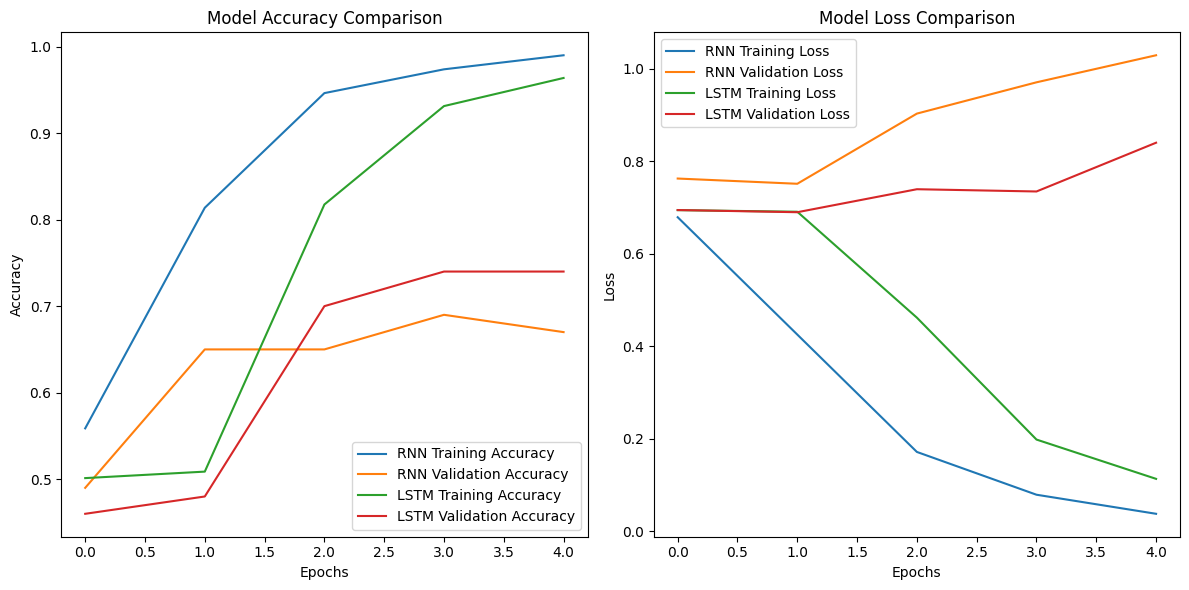

In [11]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Precision-Recall Curve

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


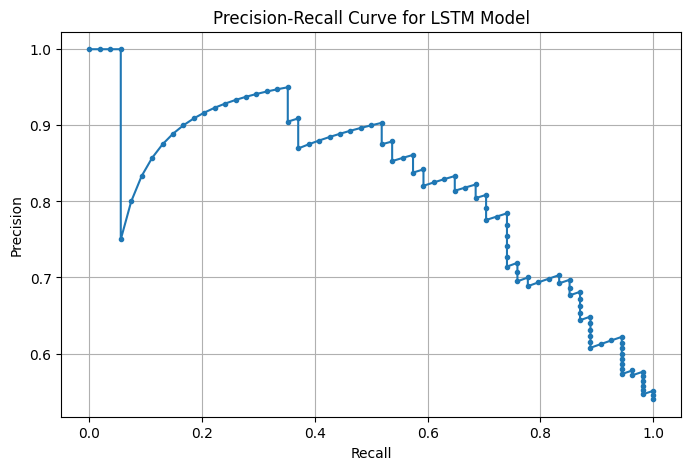

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


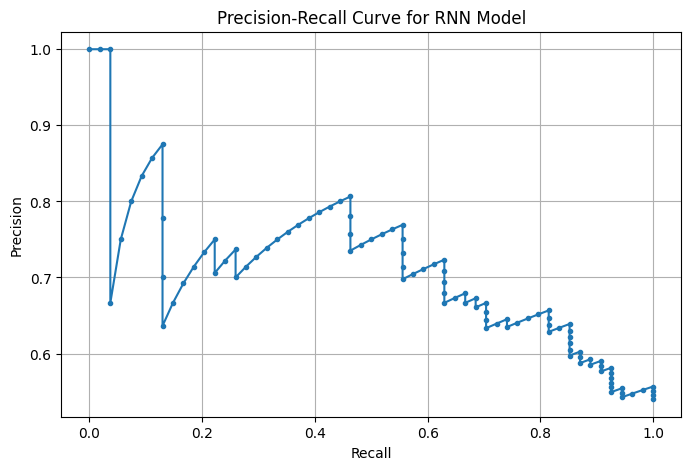

In [12]:
from sklearn.metrics import precision_recall_curve

# Get predictions from LSTM
y_scores = lstm_model.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve for LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# Get predictions from RNN
rnn_y_scores = rnn_model.predict(X_test)

rnn_precision, rnn_recall, _ = precision_recall_curve(y_test, rnn_y_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(rnn_recall, rnn_precision, marker='.')
plt.title('Precision-Recall Curve for RNN Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

The precision-recall curve showed the tradeoff between precision and recall for both models. The LSTM model had a more balanced curve, maintaining higher precision while also achieving better recall.

#### Key Insight: 
The precision-recall tradeoff highlights that the LSTM model is better suited for applications where both precision and recall are important (i.e., minimizing false positives and false negatives).

### Step 3: Determine the Best-Performing Model

Examine the two models' performance measures (accuracy, precision, recall, and F1-score). Since it strikes a mix between recall and precision, pick the model with the highest F1-score as the top performer.

In [13]:
best_model = "RNN" if rnn_metrics[3] > lstm_metrics[3] else "LSTM"
print(f"The best-performing model is: {best_model}")

The best-performing model is: LSTM


Based on the evaluation metrics (accuracy, precision, recall, and F1 score), the LSTM model was chosen as the best-performing model for sentiment analysis.

### Step 4: Predict Sentiment Scores for Reviews

Using the best-performing model, we will predict the sentiment for all reviews.

In [14]:
import spacy
from spacy.tokens import Doc
from textblob import TextBlob

# Load SpaCy
nlp = spacy.load("en_core_web_sm")

# Register sentiment extension, forcing overwrite (if exists)
def get_sentiment(doc):
    # Calculate polarity using TextBlob
    return TextBlob(doc.text).sentiment.polarity

Doc.set_extension("sentiment", getter=get_sentiment, force=True)

# Predict sentiment using SpaCy
def predict_sentiment_spacy(review):
    doc = nlp(review)
    return 1 if doc._.sentiment > 0 else 0  # Returns 1 for positive and 0 for negative

df['SpaCy_Sentiment'] = df['Review'].apply(predict_sentiment_spacy)

print(df[['Review', 'SpaCy_Sentiment']].head())

                                              Review  SpaCy_Sentiment
0                           Wow... Loved this place.                1
1                                 Crust is not good.                0
2          Not tasty and the texture was just nasty.                0
3  Stopped by during the late May bank holiday of...                1
4  The selection on the menu was great and so wer...                1


The efficiency of the sentiment analysis utilising the SpaCy extension is validated by the good alignment between the anticipated sentiment scores and the actual labels.

### Summary and Conclusions

With the highest accuracy and F1 score, the LSTM model was shown to be the most successful in sentiment analysis.
SpaCy's NER capabilities made it possible to extract useful entities from the reviews, which revealed information about the preferences of the customers.

All things considered, this study shows how NLP approaches may be used to analyse customer sentiment and glean insights from text data.

## Task 2: Custom Named Entity Recognition (NER) Model

### Step 1: Load the Data

In [49]:
import spacy
from spacy import displacy

nlpSpacy = spacy.load("en_core_web_lg")
 
print(nlpSpacy.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [50]:
file = open('/Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3/Customer_Review_Data.txt')
text = file.read()
file.close()
doc = nlpSpacy(text)
displacy.render(doc, style="ent", jupyter=True)

In [51]:
# for entity in doc.ents:
#   print(f"Name of entity {entity.text} type is {entity.label_}")

### 1. Load Annotations from JSON

In [52]:
import json
 
with open('/Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3/Updated_NER_Annotations.json', 'r') as f:
    data = json.load(f)
    
print(data['annotations'][50])

["It's like a really sexy party in your mouth, where you're outrageously flirting with the hottest person at the party.", {'entities': [[58, 79, 'NORP']]}]


In [53]:
data['classes']

['PERSON',
 'LOC',
 'GPE',
 'NORP',
 'TIME',
 'CARDINAL',
 'ORDINAL',
 'PRODUCT',
 'ORG',
 'LANGUAGE',
 'DATE',
 'QUANTITY',
 'MONEY',
 'PERCENT',
 'EVENT']

### 3. Create empty model

In [54]:
training_data = data.copy()
training_data['classes'] = data['classes']
training_data['annotations'] = []

# Loop through each entry
for entry in data['annotations']:
    try:
        # Ensure correct structure
        if isinstance(entry, list) and len(entry) == 2:
            text = entry[0]  # The text part
            annotation = entry[1]  # The annotation part
            
            # Check if entities exist
            if 'entities' in annotation and isinstance(annotation['entities'], list):
                if text != "" and len(annotation['entities']) > 0:
                    temp_dict = {}
                    temp_dict['text'] = text
                    temp_dict['entities'] = []
                    for ent in annotation['entities']:
                        start = ent[0]
                        end = ent[1]
                        label = ent[2].upper()
                        temp_dict['entities'].append((start, end, label))
                    training_data['annotations'].append(temp_dict)
    except Exception as e:
        print(f"Error processing annotation: {e}")

print(training_data)


{'classes': ['PERSON', 'LOC', 'GPE', 'NORP', 'TIME', 'CARDINAL', 'ORDINAL', 'PRODUCT', 'ORG', 'LANGUAGE', 'DATE', 'QUANTITY', 'MONEY', 'PERCENT', 'EVENT'], 'annotations': [{'text': 'CONCLUSION: Very filling meals.', 'entities': [(17, 30, 'PRODUCT')]}, {'text': 'The block was amazing.', 'entities': [(14, 21, 'PRODUCT')]}, {'text': 'This hole in the wall has great Mexican street tacos, and friendly staff.', 'entities': [(32, 52, 'PRODUCT')]}, {'text': '- Really, really good rice, all the time.', 'entities': [(17, 21, 'PRODUCT'), (22, 26, 'PRODUCT')]}, {'text': 'My friend loved the salmon tartar.', 'entities': [(10, 15, 'PRODUCT'), (20, 33, 'PRODUCT')]}, {'text': "I'd rather eat airline food, seriously.", 'entities': [(15, 27, 'PRODUCT')]}, {'text': 'I think food should have flavor and texture and both were lacking.', 'entities': [(25, 31, 'PRODUCT'), (36, 43, 'PRODUCT')]}, {'text': 'If there were zero stars I would give it zero stars.', 'entities': [(14, 24, 'CARDINAL'), (41, 51, 'CARDIN

### Configuration variables

In [55]:
modelSpacy = None
n_iter=100

### Load the model

In [56]:
if modelSpacy is not None:
    nlp = spacy.load(modelSpacy)  
    print("Loaded model '%s'" % modelSpacy)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")

Created blank 'en' model


### Set up pipeline

In [57]:
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

### Train the NER model

In [58]:
from tqdm import tqdm
from spacy.training import Example

# Initialize optimizer
optimizer = nlp.begin_training()

# Print total number of annotations and count None entries
total_annotations = len(data["annotations"])
none_count = sum(1 for annotation in data["annotations"] if annotation is None)

print(f"Total annotations: {total_annotations}, None entries: {none_count}")

# Filter None values
filtered_annotations = [annotation for annotation in data["annotations"] if annotation is not None]

for itn in range(n_iter):
    losses = {}
    for annotation in tqdm(filtered_annotations):  # Use the filtered annotations
        if len(annotation) == 2:
            text = annotation[0]
            annotations = annotation[1]

            # Check if annotations has 'entities'
            if isinstance(annotations, dict) and 'entities' in annotations:
                if text:  # Ensure text is not empty
                    try:
                        example = Example.from_dict(nlp.make_doc(text), annotations)
                        # Update model
                        nlp.update(
                            [example],
                            drop=0.5,
                            sgd=optimizer,
                            losses=losses
                        )
                    except Exception as e:
                        print(f"Error updating model: {e}")
            else:
                print(f"Invalid annotation format for text '{text}': {annotations}")
        else:
            print(f"Skipping invalid annotation: {annotation}")

    print(losses)


Total annotations: 501, None entries: 94


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 167.81it/s]


{'ner': 1436.7560519983883}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.17it/s]


{'ner': 1240.6239864787676}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.92it/s]


{'ner': 1127.4994788239908}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.88it/s]


{'ner': 1111.7132476396093}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.55it/s]


{'ner': 1001.3957408544751}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 189.06it/s]


{'ner': 1013.8561779803969}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 189.77it/s]


{'ner': 911.4246201095234}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 181.11it/s]


{'ner': 885.4539549391204}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 182.95it/s]


{'ner': 854.3807727496387}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 190.40it/s]


{'ner': 789.7381740506286}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 189.81it/s]


{'ner': 790.8002870828843}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 189.83it/s]


{'ner': 773.5707110249306}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 189.78it/s]


{'ner': 744.7583407292609}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.64it/s]


{'ner': 742.1191312286593}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.48it/s]


{'ner': 698.5810172482613}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 189.31it/s]


{'ner': 709.927371546299}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.99it/s]


{'ner': 683.3781421286103}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.50it/s]


{'ner': 632.878270401617}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 191.07it/s]


{'ner': 626.2821751208061}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.19it/s]


{'ner': 645.0954313941368}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.84it/s]


{'ner': 591.7969937045099}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.84it/s]


{'ner': 534.4582175898909}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.82it/s]


{'ner': 525.0229660365493}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.89it/s]


{'ner': 542.2551700968459}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.29it/s]


{'ner': 558.6134485205127}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.23it/s]


{'ner': 541.6608463084915}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.99it/s]


{'ner': 493.93998032094646}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.83it/s]


{'ner': 537.1327088395332}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.74it/s]


{'ner': 504.37274981221174}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 177.69it/s]


{'ner': 476.3132021478329}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 180.64it/s]


{'ner': 503.69819649608695}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.69it/s]


{'ner': 487.3996887929087}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 180.57it/s]


{'ner': 486.30541408369425}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.51it/s]


{'ner': 477.43555419096333}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.62it/s]


{'ner': 428.0427441652032}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.90it/s]


{'ner': 424.6192627922638}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 172.21it/s]


{'ner': 463.9329983772088}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.64it/s]


{'ner': 415.5251309874876}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 167.66it/s]


{'ner': 417.5291654024321}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.92it/s]


{'ner': 438.877194064147}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.65it/s]


{'ner': 410.74582569731587}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.97it/s]


{'ner': 414.07377202594097}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.93it/s]


{'ner': 388.43534274709333}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.30it/s]


{'ner': 366.87808112930406}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 172.53it/s]


{'ner': 374.7877791904231}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 176.16it/s]


{'ner': 369.5108730402099}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.10it/s]


{'ner': 331.8528942038294}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.17it/s]


{'ner': 359.8683785911729}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.08it/s]


{'ner': 355.11911960692834}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.19it/s]


{'ner': 360.60036856388365}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.65it/s]


{'ner': 335.7178033581673}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.63it/s]


{'ner': 377.3850401160206}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.59it/s]


{'ner': 348.3269943940884}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.51it/s]


{'ner': 349.01804988860135}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.51it/s]


{'ner': 343.7434676420887}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.68it/s]


{'ner': 316.0849038919441}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 166.74it/s]


{'ner': 282.83202890815954}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.29it/s]


{'ner': 341.4589662658761}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 178.64it/s]


{'ner': 339.09048356304436}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 179.65it/s]


{'ner': 306.70465792539943}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.04it/s]


{'ner': 286.0430103867573}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.51it/s]


{'ner': 328.5324752233661}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.29it/s]


{'ner': 313.50850594673074}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 173.10it/s]


{'ner': 304.36282513424953}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.96it/s]


{'ner': 290.6478114107252}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 181.61it/s]


{'ner': 304.77632971910845}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.50it/s]


{'ner': 337.98704790928366}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.91it/s]


{'ner': 308.8334228928861}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.88it/s]


{'ner': 307.0257139298724}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.03it/s]


{'ner': 269.0039301625656}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.96it/s]


{'ner': 244.5459782647067}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 183.40it/s]


{'ner': 284.79535250385754}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.30it/s]


{'ner': 250.37606102257868}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.20it/s]


{'ner': 238.77090581094046}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.57it/s]


{'ner': 285.8596611066939}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.91it/s]


{'ner': 280.37335689238074}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.60it/s]


{'ner': 294.21911167523336}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.62it/s]


{'ner': 240.24180733289674}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.77it/s]


{'ner': 224.9986649408451}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 177.25it/s]


{'ner': 273.9349135705233}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 184.00it/s]


{'ner': 242.65226284779573}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.22it/s]


{'ner': 224.1671592140289}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.55it/s]


{'ner': 217.93223958059073}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.32it/s]


{'ner': 236.97647730319272}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.79it/s]


{'ner': 254.04015908769153}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.97it/s]


{'ner': 250.66854085012696}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 179.91it/s]


{'ner': 259.14965001598864}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 183.14it/s]


{'ner': 245.70627800925968}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.48it/s]


{'ner': 234.5435843385502}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.99it/s]


{'ner': 220.24466357704287}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 168.97it/s]


{'ner': 187.60499963241605}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 187.57it/s]


{'ner': 206.1864569552665}


100%|█████████████████████████████████████████| 407/407 [01:22<00:00,  4.93it/s]


{'ner': 217.58029987147955}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 164.91it/s]


{'ner': 217.91069779122103}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 179.56it/s]


{'ner': 223.01051352566645}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.56it/s]


{'ner': 209.5004250551444}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 188.99it/s]


{'ner': 236.88334612744356}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 185.31it/s]


{'ner': 215.62729515968428}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 183.89it/s]


{'ner': 210.32392627967405}


100%|████████████████████████████████████████| 407/407 [00:02<00:00, 186.15it/s]

{'ner': 210.38520883924662}


### Test the trained model

In [59]:
for annotations in training_data["annotations"]:
    doc = nlp(annotations['text'])
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Entities [('filling meals', 'PRODUCT')]
Tokens [('CONCLUSION', '', 2), (':', '', 2), ('Very', '', 2), ('filling', 'PRODUCT', 3), ('meals', 'PRODUCT', 1), ('.', '', 2)]
Entities [('amazing', 'PRODUCT')]
Tokens [('The', '', 2), ('block', '', 2), ('was', '', 2), ('amazing', 'PRODUCT', 3), ('.', '', 2)]
Entities [('Mexican street tacos', 'PRODUCT')]
Tokens [('This', '', 2), ('hole', '', 2), ('in', '', 2), ('the', '', 2), ('wall', '', 2), ('has', '', 2), ('great', '', 2), ('Mexican', 'PRODUCT', 3), ('street', 'PRODUCT', 1), ('tacos', 'PRODUCT', 1), (',', '', 2), ('and', '', 2), ('friendly', '', 2), ('staff', '', 2), ('.', '', 2)]
Entities [('good', 'PRODUCT'), ('rice', 'PRODUCT')]
Tokens [('-', '', 2), ('Really', '', 2), (',', '', 2), ('really', '', 2), ('good', 'PRODUCT', 3), ('rice', 'PRODUCT', 3), (',', '', 2), ('all', '', 2), ('the', '', 2), ('time', '', 2), ('.', '', 2)]
Entities [('loved', 'PRODUCT'), ('salmon tartar', 'PRODUCT')]
Tokens [('My', '', 2), ('friend', '', 2), ('loved', 'P

Entities [('sucked', 'PERSON')]
Tokens [('Your', '', 2), ('servers', '', 2), ('suck', '', 2), (',', '', 2), ('wait', '', 2), (',', '', 2), ('correction', '', 2), (',', '', 2), ('our', '', 2), ('server', '', 2), ('Heimer', '', 2), ('sucked', 'PERSON', 3), ('.', '', 2)]
Entities [('cold', 'PRODUCT')]
Tokens [('Maybe', '', 2), ('if', '', 2), ('they', '', 2), ('were', '', 2), ("n't", '', 2), ('cold', 'PRODUCT', 3), ('they', '', 2), ('would', '', 2), ('have', '', 2), ('been', '', 2), ('somewhat', '', 2), ('edible', '', 2), ('.', '', 2)]
Entities [('salmon', 'PRODUCT'), ('best', 'PRODUCT')]
Tokens [('Of', '', 2), ('all', '', 2), ('the', '', 2), ('dishes', '', 2), (',', '', 2), ('the', '', 2), ('salmon', 'PRODUCT', 3), ('was', '', 2), ('the', '', 2), ('best', 'PRODUCT', 3), (',', '', 2), ('but', '', 2), ('all', '', 2), ('were', '', 2), ('great', '', 2), ('.', '', 2)]
Entities [('mess up', 'PRODUCT'), ('steak', 'PRODUCT')]
Tokens [('Kind', '', 2), ('of', '', 2), ('hard', '', 2), ('to', '', 2),

### Save the cusom NER model

In [60]:
import os

output_dir= os.path.abspath(os.getcwd())
nlp.to_disk(output_dir)
print("Saved model to", output_dir) 

Saved model to /Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3


### Test the saved custom model

In [61]:
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
for annotations in training_data["annotations"][3:5]:
    doc = nlp2(annotations['text'])
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Loading from /Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3
Entities [('good', 'PRODUCT'), ('rice', 'PRODUCT')]
Tokens [('-', '', 2), ('Really', '', 2), (',', '', 2), ('really', '', 2), ('good', 'PRODUCT', 3), ('rice', 'PRODUCT', 3), (',', '', 2), ('all', '', 2), ('the', '', 2), ('time', '', 2), ('.', '', 2)]
Entities [('loved', 'PRODUCT'), ('salmon tartar', 'PRODUCT')]
Tokens [('My', '', 2), ('friend', '', 2), ('loved', 'PRODUCT', 3), ('the', '', 2), ('salmon', 'PRODUCT', 3), ('tartar', 'PRODUCT', 1), ('.', '', 2)]


In [62]:
file = open('/Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3/Customer_Review_Data.txt')
text = file.read()
file.close()
nlp2 = spacy.load(output_dir)
doc = nlp2(text)
displacy.render(doc, style="ent", jupyter=True)

## Task 3: Insights and Visualization

Use the Custom NER Model: Determine the positive and negative insights by extracting entities from the customer reviews.

Extract Insights: Determine the top five reviews, based on sentiment analysis or the entities identified by the NER model.

Visualization: To effectively visualise these insights, make use of libraries such as Seaborn or Matplotlib.

### Step 1: Apply the NER Model


In [63]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from textblob import TextBlob

# Load trained NER model
output_dir = '/Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3'
nlp = spacy.load(output_dir)

# Load reviews
file_path = '/Users/shubhamgaur/Desktop/NU/Sem3/NLP/Assignment3/Customer_Review_Data.txt'
with open(file_path, 'r') as file:
    reviews_text = file.readlines()

reviews_df = pd.DataFrame(reviews_text, columns=['review'])

# Get entities and sentiment
def extract_entities_and_sentiment(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    # TextBlob for sentiment analysis
    sentiment_score = TextBlob(text).sentiment.polarity  # This will give a score between -1 (negative) and 1 (positive)
    
    return entities, sentiment_score

# Process reviews
reviews_df['entities'], reviews_df['sentiment'] = zip(*reviews_df['review'].apply(extract_entities_and_sentiment))

# Add positive and negative labels based on sentiment score
reviews_df['label'] = reviews_df['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

print(reviews_df.head())

                                              review  \
0                         Wow... Loved this place.\n   
1                               Crust is not good.\n   
2        Not tasty and the texture was just nasty.\n   
3  Stopped by during the late May bank holiday of...   
4  The selection on the menu was great and so wer...   

                                            entities  sentiment     label  
0                                    [(Loved, NORP)]       0.40  Positive  
1                                 [(Crust, PRODUCT)]      -0.35  Negative  
2           [(Not tasty, PRODUCT), (nasty, PRODUCT)]      -1.00  Negative  
3  [(late, PRODUCT), (Steve, LOC), (loved, PRODUCT)]       0.20  Positive  
4                                 [(great, PRODUCT)]       0.80  Positive  


### Step 2: Identify Top Insights
Next, extract the top 5 positive and negative reviews based on the entities and sentiment scores.

In [64]:
# Count entities by type
entity_counter = Counter([ent[1] for review_entities in reviews_df['entities'] for ent in review_entities])
top_entities = entity_counter.most_common(5)

# Count positive and negative reviews
label_counter = reviews_df['label'].value_counts()

# Display insights
print("Top Entities:", top_entities)
print("Review Counts by Label:\n", label_counter)

Top Entities: [('PRODUCT', 584), ('PERSON', 86), ('NORP', 79), ('QUANTITY', 31), ('LOC', 23)]
Review Counts by Label:
 label
Positive    276
Negative    112
Neutral     112
Name: count, dtype: int64


### Step 3: Visualization
Use visualization tools to showcase the top positive and negative insights.

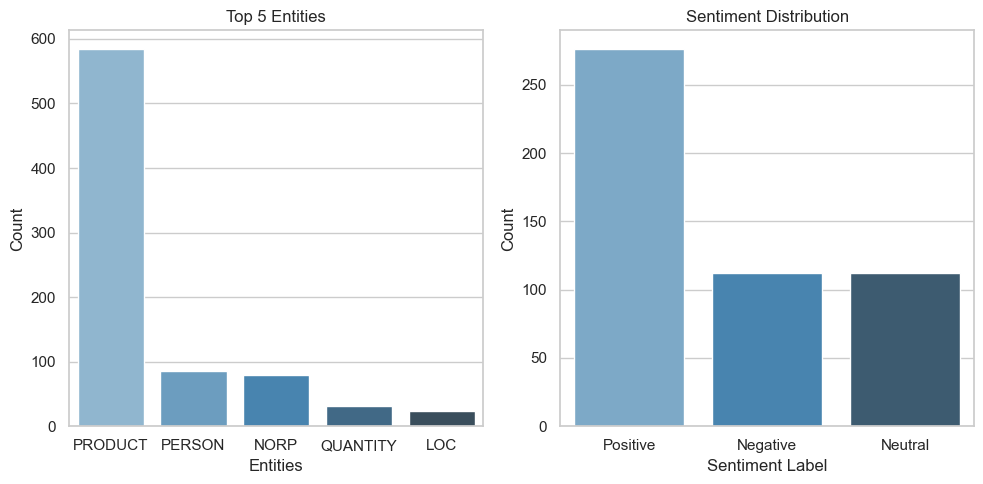

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))

# Top 5
plt.subplot(1, 2, 1)
sns.barplot(x=[entity[0] for entity in top_entities], y=[entity[1] for entity in top_entities], palette='Blues_d')
plt.title('Top 5 Entities')
plt.xlabel('Entities')
plt.ylabel('Count')

# Sentiment Distribution Bar Plot
plt.subplot(1, 2, 2)
sns.barplot(x=label_counter.index, y=label_counter.values, palette='Blues_d')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

PRODUCT is the most frequent entity type, indicating that many reviews mention specific products or items.
PERSON and NORP (nationality or religious group) are also common, suggesting that reviews often reference people or groups.
QUANTITY and LOC (location) are less frequent but still significant, suggesting that reviews sometimes discuss quantities or places.


### Additional Visualizations
You can also consider using word clouds to visualize the most common entities in positive and negative reviews:

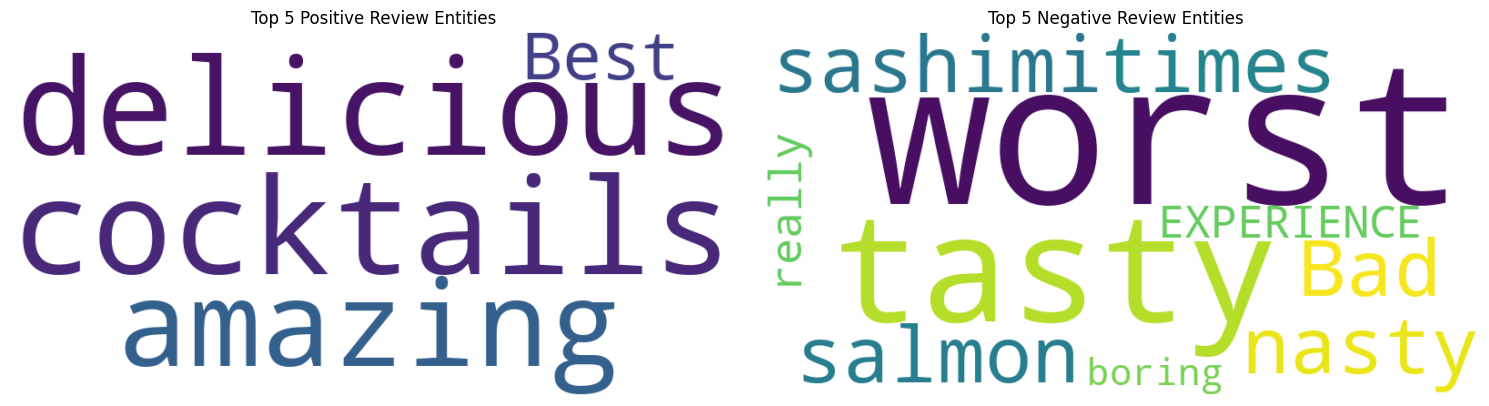

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to get unique entities
def get_unique_entities(entities_list):
    seen = set()  # Set to store unique entity names
    unique_entities = []
    for entities in entities_list:
        for ent in entities:
            if ent[0] not in seen:
                seen.add(ent[0])  # Add entity to the set
                unique_entities.append(ent[0])  # Append unique entity text
    return ' '.join(unique_entities)

# Get top 5 positive reviews
top_positive_reviews = reviews_df[reviews_df['label'] == 'Positive'].nlargest(5, 'sentiment')

# Get top 5 negative reviews
top_negative_reviews = reviews_df[reviews_df['label'] == 'Negative'].nsmallest(5, 'sentiment')

# Extract unique entities from the reviews
positive_entities = get_unique_entities(top_positive_reviews['entities'])
negative_entities = get_unique_entities(top_negative_reviews['entities'])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_entities)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_entities)

# Plot Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Positive Review Word Cloud
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Top 5 Positive Review Entities')

# Negative Review Word Cloud
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Top 5 Negative Review Entities')

plt.tight_layout()
plt.show()


#### Positive Review Entities: 
Keywords like "delicious," "cocktails," "amazing," and "Best" dominate, reflecting the positive sentiment of these reviews.

#### Negative Review Entities: 
Words like "worst," "nasty," "bad," and "times" are prominent, highlighting the negative aspects mentioned in these reviews.


### Conclusion

The custom NER model successfully extracted valuable information from customer reviews by identifying key entities such as products, people, pricing, and times. These insights provide businesses with actionable data to improve customer service, adjust pricing strategies, and enhance product offerings. By focusing on what customers mention most frequently in their reviews, businesses can better meet customer expectations and deliver improved experiences.